In [345]:
import pandas as pd
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

In [346]:
# Source https://github.com/Mentalab-hub/explorepy/blob/master/examples/ssvep_demo/offline_analysis.py
def custom_filter(exg, lf, hf, fs, type):
    """
    
    Args:
        exg: EEG signal with the shape: (N_chan, N_sample)
        lf: Low cutoff frequency
        hf: High cutoff frequency
        fs: Sampling rate
        type: Filter type, 'bandstop' or 'bandpass'

    Returns:
        (numpy ndarray): Filtered signal (N_chan, N_sample)
    """
    N = 4
    b, a = signal.butter(N, [lf / (fs/2), hf / (fs/2)], type)
    return signal.filtfilt(b, a, exg)

In [347]:
# Initialization
fs = 250 #Hz
lf = 1 #Hz
hf = 30 #Hz

chan_name = ['POz', 'PO3', 'PO4', 'PO7', 'O2', 'O1', 'Oz', 'PO8']
n_chan = len(chan_name)
chan_list = ['ch' + str(i) for i in range(1, n_chan + 1)]

In [348]:
# Import data
eeg_7_5 = pd.read_csv('data/SSVEP_VR_1m/7_5_ssvep_ExG.csv')
eeg_10 = pd.read_csv('data/SSVEP_VR_1m/10_ssvep_ExG.csv')
eeg_resting = pd.read_csv('data/SSVEP_VR_1m/resting_ExG.csv')

In [349]:
sig_eeg_7_5 = eeg_7_5[chan_list].to_numpy().T
sig_eeg_10 = eeg_10[chan_list].to_numpy().T
sig_eeg_resting = eeg_resting[chan_list].to_numpy().T

In [350]:
# Signal filtering, bandpass 1-30Hz, bandstop 45-55Hz
def filt(sig,fs=250, lf=1, hf=30):
    filt_sig = custom_filter(sig, 45, 55, fs, 'bandstop') 
    filt_sig = custom_filter(filt_sig, lf, hf, fs, 'bandpass')
    return filt_sig

In [351]:
# Filter the signal
filt_sig_eeg_7_5 = filt(sig_eeg_7_5)
filt_sig_eeg_10 = filt(sig_eeg_10)
filt_sig_eeg_resting = filt(sig_eeg_resting)

In [352]:
def amplitude_plot(filt_signal, chan_name, title = '', fs=250, lim = 150,xlim=None):
    n_samples = filt_signal.shape[1]

    # Generate a time vector for the signal
    t = np.arange(n_samples) / fs

    # Create a single plot with a single subplot
    fig, ax = plt.subplots(figsize=(15, 3))

    # Loop through each signal and plot it on the same subplot
    for i in range(len(filt_signal)):
        ax.plot(t, filt_signal[i], label='{}'.format(chan_name[i]))

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.set_ylim(-1*lim, lim)
    if xlim:
        ax.set_xlim(0, xlim)
    ax.legend()
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


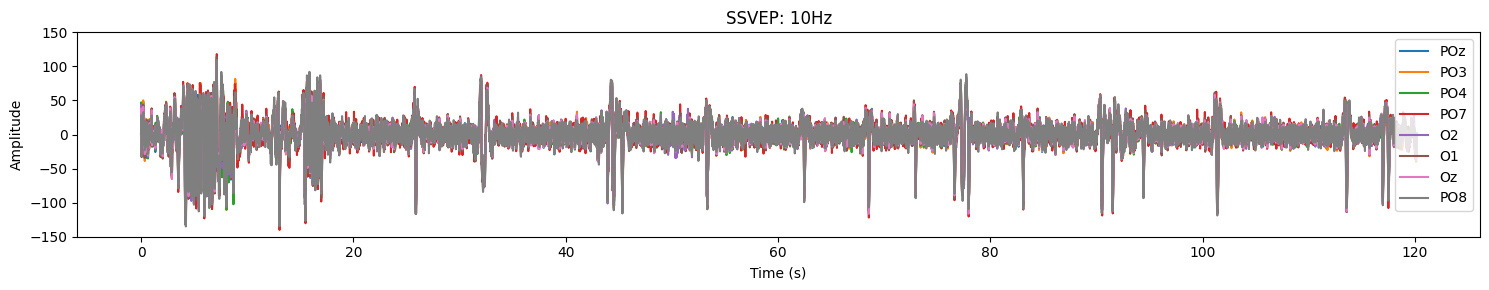

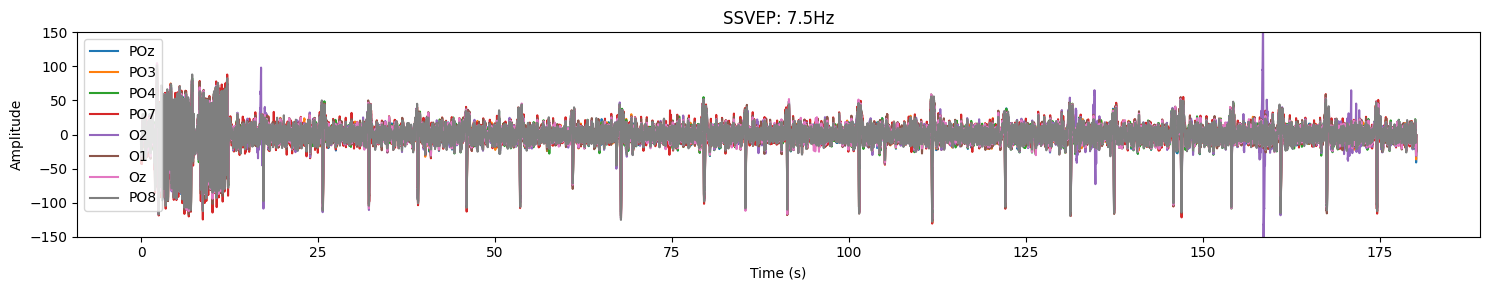

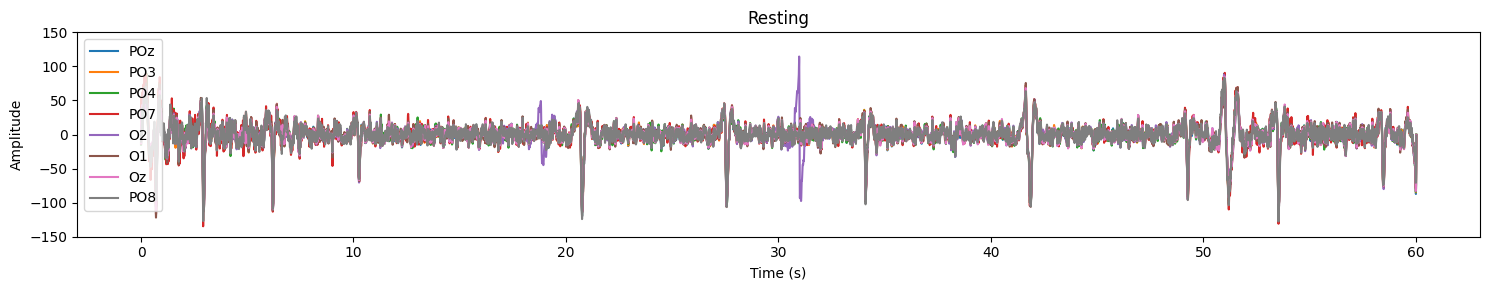

In [353]:
# Plot the signal amplitude VS time
amplitude_plot(filt_sig_eeg_10,chan_name, title = "SSVEP: 10Hz")
amplitude_plot(filt_sig_eeg_7_5,chan_name,title = 'SSVEP: 7.5Hz')
amplitude_plot(filt_sig_eeg_resting,chan_name,title = 'Resting')

In [354]:
def cut_signal(filt_signal, start, end, fs=250):
    cut_start = int(start * fs)
    cut_end = int(end * fs)
    output = []

    for i in range(0,len(filt_signal)):
        output.append(filt_signal[i][cut_start:len(filt_signal[i])-cut_end])
    return np.array(output)

In [355]:
# Cut the signal so that the first 20 seconds and the last 10 seconds are removed
filt_sig_eeg_10 = cut_signal(filt_sig_eeg_10,20,10)
filt_sig_eeg_7_5 = cut_signal(filt_sig_eeg_7_5,20,10)
filt_sig_eeg_resting = cut_signal(filt_sig_eeg_resting,20,10)

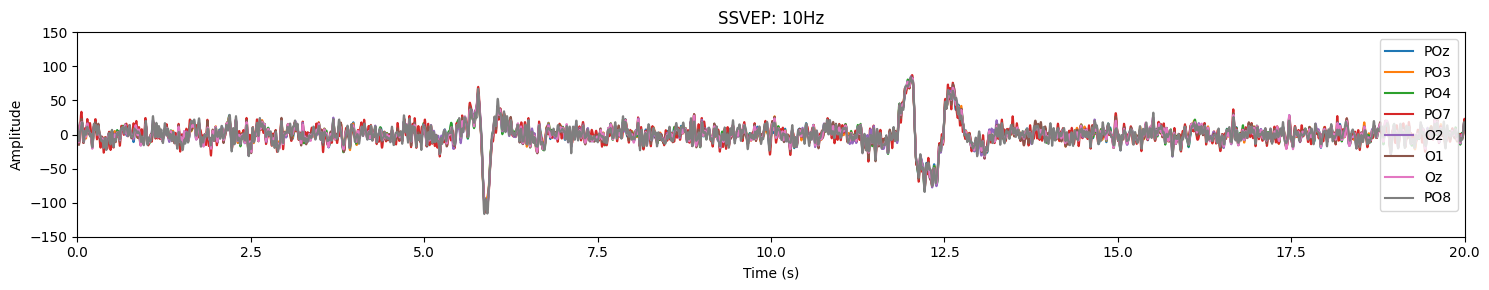

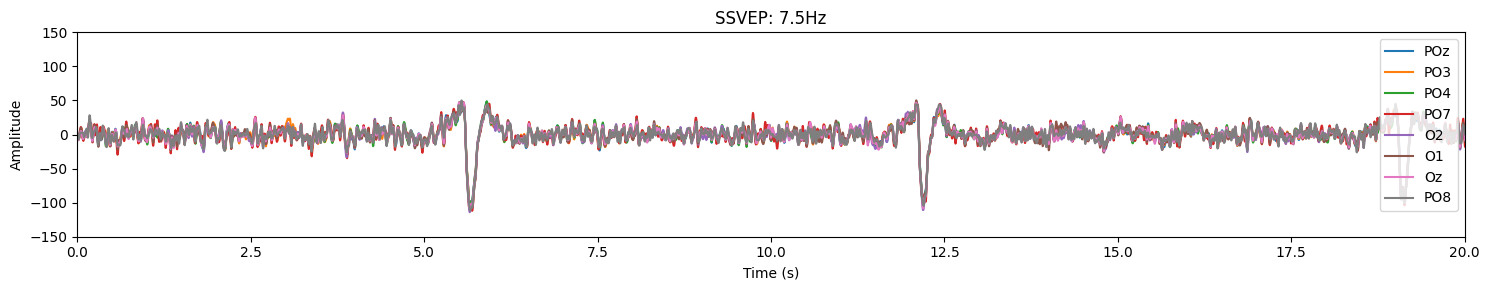

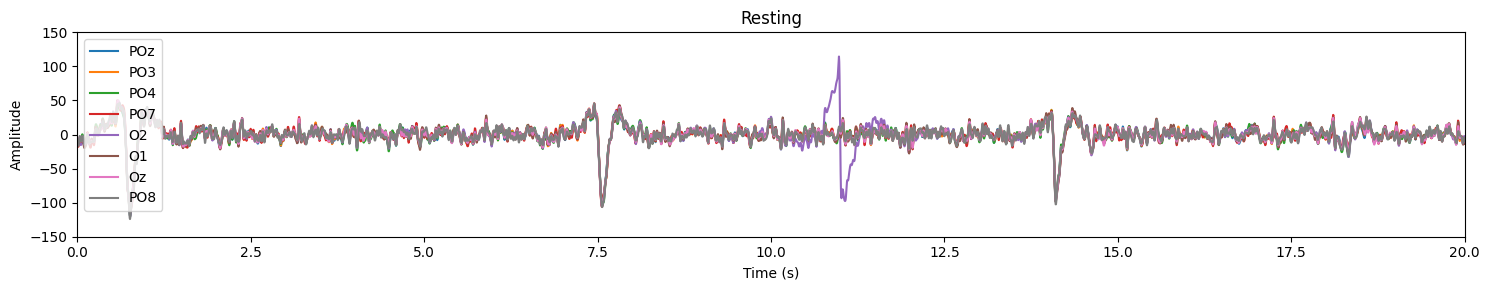

In [356]:
# The first 20 seconds of the cut signal
amplitude_plot(filt_sig_eeg_10,chan_name, title = "SSVEP: 10Hz", xlim=20)
amplitude_plot(filt_sig_eeg_7_5,chan_name,title = 'SSVEP: 7.5Hz',xlim=20)
amplitude_plot(filt_sig_eeg_resting,chan_name,title = 'Resting', xlim=20)

In [364]:
def psd_plot(filt_signal, chan_name, title='', fs=250, x_min=1, x_lim=30, y_lim = 125, line=None):
    n_samples = filt_signal.shape[1]

    # Generate a time vector for the signal
    t = np.arange(n_samples) / fs

    # Create a single plot with a single subplot
    fig, ax = plt.subplots(figsize=(15, 3))

    # Loop through each signal and plot it on the same subplot
    for i in range(len(filt_signal)):
        f, psd = signal.welch(filt_signal[i], fs=fs)
        ax.plot(f, psd, label='{}'.format(chan_name[i]))

    if line:
        ax.axvline(x=line, color='gray', linestyle='--')
        ax.text(line+0.2, 20, 'f = '+str(line)+'Hz', fontsize=12, color='gray')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('PSD (V^2/Hz)')
    ax.set_xlim(x_min, x_lim)
    ax.set_ylim(0, y_lim)
    ax.legend()
    ax.set_title('PSD ' + title)
    plt.tight_layout()
    plt.show()


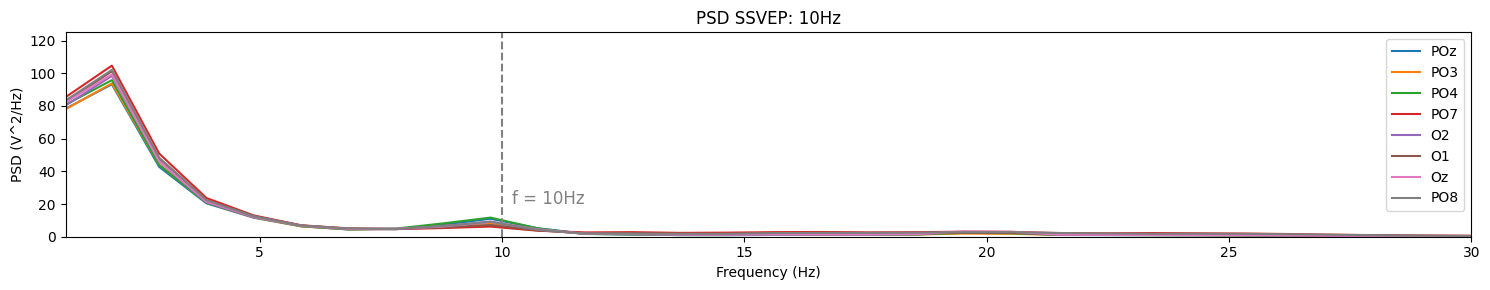

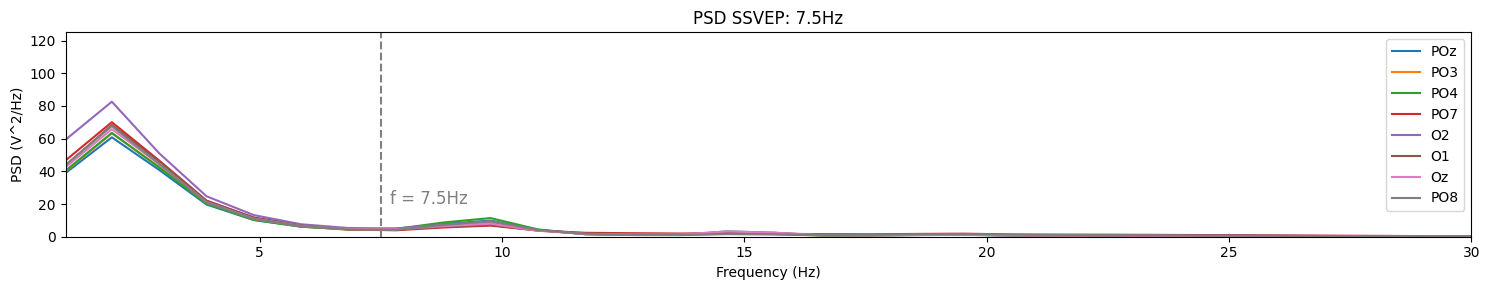

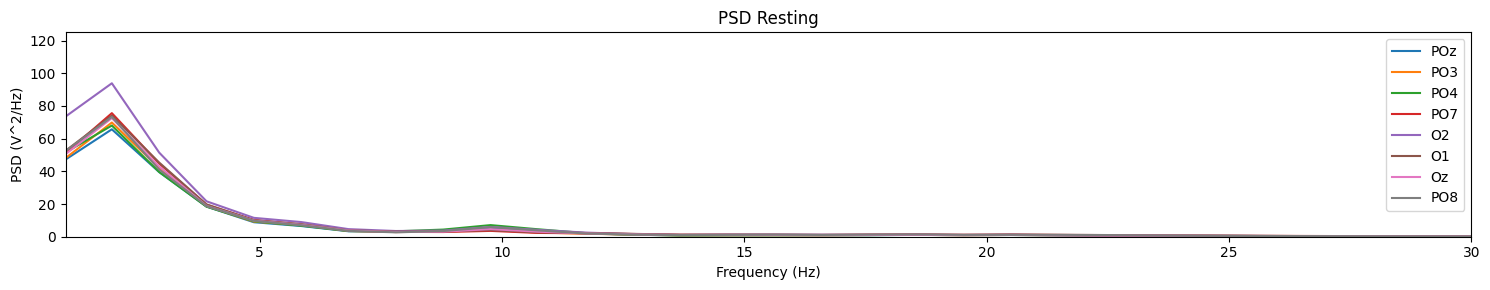

In [365]:
# Plot the signal PSD
psd_plot(filt_sig_eeg_10,chan_name, title = "SSVEP: 10Hz", line=10)
psd_plot(filt_sig_eeg_7_5,chan_name,title = 'SSVEP: 7.5Hz',line=7.5)
psd_plot(filt_sig_eeg_resting,chan_name,title = 'Resting')

In [359]:
# keep only the first ~20 seconds of each signal
start_filt_sig_eeg_10 = cut_signal(filt_sig_eeg_10,0,50)
start_filt_sig_eeg_7_5 = cut_signal(filt_sig_eeg_7_5,0,110)

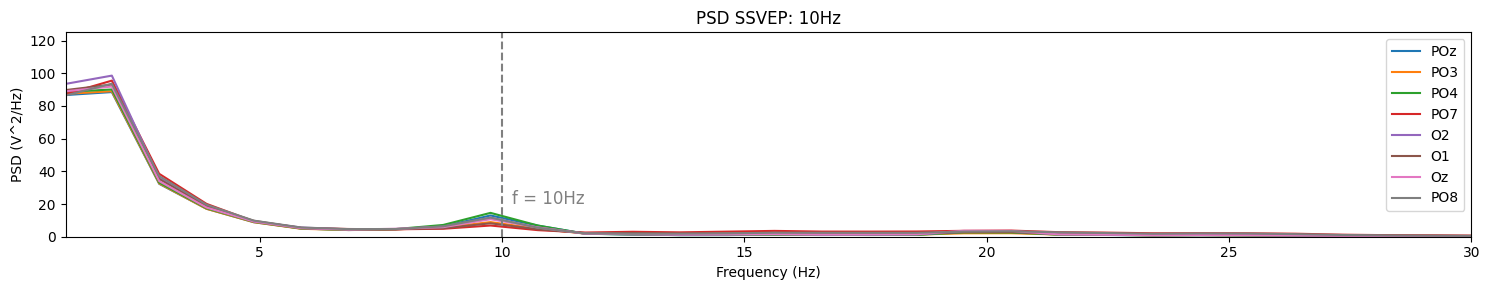

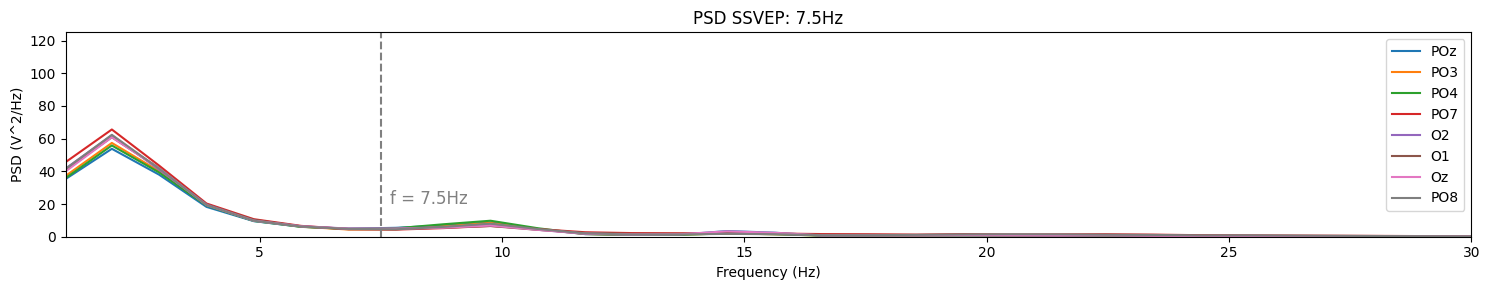

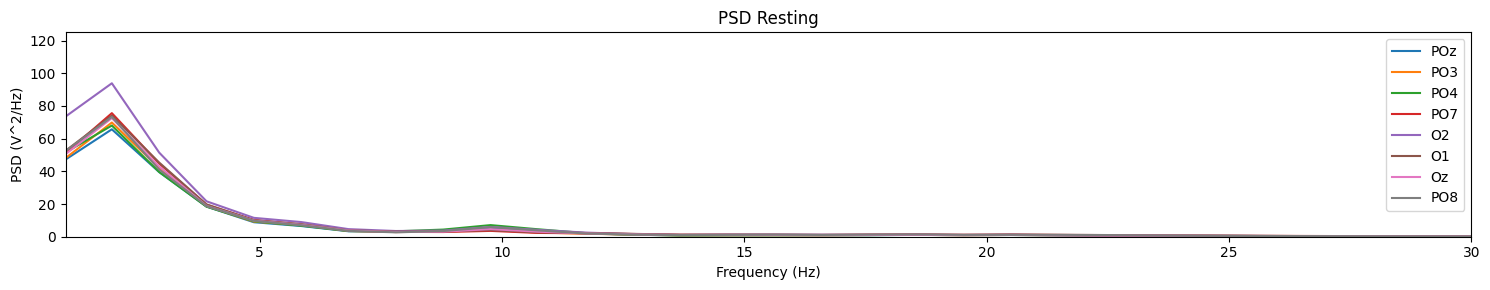

In [366]:
psd_plot(start_filt_sig_eeg_10,chan_name, title = "SSVEP: 10Hz", line=10)
psd_plot(start_filt_sig_eeg_7_5,chan_name,title = 'SSVEP: 7.5Hz',line=7.5)
psd_plot(filt_sig_eeg_resting,chan_name,title = 'Resting')